In [1]:
from sentiment.modeling import *
from sentiment.data_loader import *
from sentiment.training import *
from transformers import BertTokenizer
import pandas as pd
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader
from utils import *
import ast
from clean_text import *



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/furkan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/furkan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/furkan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def create_data_load(df, tokenizer, max_len, batch_size):
    collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
    ds = NewsDataset(
        news=df.news.to_list(),
        labels = [None]* len(df),
        tokenizer=tokenizer,
        max_len=max_len,
        train=False
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        collate_fn=collator)

In [20]:
def get_pred(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = F.softmax(outputs, dim =1)
            predictions.extend(preds)
            prediction_probs.extend(probs)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return predictions, prediction_probs


In [3]:
stock_names = ["apple", "amazon", "google"]
candidate_labels_nasdaq = ['apple', 'amazon', 'google', 'stock market', 'not stock market']

In [4]:
model_bert = SentimentClassifier(2, "bert-base-uncased", do_fine_tune = False).to(device)
model_bert.load_state_dict(torch.load("sentiment/saved_models/bert-base-with-dropout.bin")) # tried to load different model - 

<All keys matched successfully>

In [5]:
model_finbert = SentimentClassifier(2, "ProsusAI/finbert", do_fine_tune = False).to(device)
model_finbert.load_state_dict(torch.load("sentiment/saved_models/finbert-fine-tune.bin")) # tried to load different model - 

<All keys matched successfully>

In [6]:
combined_df = concat_excels("data/investing/combined.xlsx", "data/investing/apple.xlsx", "data/investing/amazon.xlsx", "data/investing/google.xlsx")
combined_df.drop(columns = ["Unnamed: 0", "url"], inplace=True)
combined_df.rename(columns={"headline": "news"}, inplace=True)
combined_df['news old'] = combined_df['news']
combined_df["news"] = combined_df["news"].apply(lambda x: textCleaning(x))
combined_df.drop_duplicates(subset=['news'], inplace=True)


## Classification of News

In [7]:
candidate_labels_nasdaq = ['apple', 'amazon', 'google', 'stock market', 'other']
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [8]:
def topic_classify(df, classifier, th = 0.5):
    
    df['stock market'] = None
    df['stock names'] = None
    for index, row in df.iterrows():
        valid_labels = []
        temp = classifier(row['news'], candidate_labels_nasdaq, multi_label= True)
        for i in range(len(temp["labels"])):
            if temp['scores'][i] >= th and temp['labels'][i] != "not stock market":
                if temp['labels'][i] == "stock market":
                    df['stock market'][index] = temp['scores'][i]
                else:
                    valid_labels.append((temp['labels'][i], temp['scores'][i]))
        df['stock names'][index] = valid_labels if len(valid_labels) > 0 else None
        
    return df
    

In [9]:
df = topic_classify(combined_df, classifier, th = 0.4 )
df.to_excel("topic_classified.xlsx", index=False)

KeyboardInterrupt: 

## Sentiment Classification

In [10]:
topic_classified = pd.read_excel("topic_classified.xlsx")
topic_classified.shape

(1800, 6)

In [11]:
cpy = topic_classified.copy()
cpy.dropna(inplace=True)
cpy.reset_index(drop=True, inplace=True)
cpy.head()

stock_market_related = pd.DataFrame(topic_classified.dropna(subset=["stock market", "stock names"]))



In [12]:
def sanitize_date(date):
    return date.split()[0]

In [13]:
import ast
def prepare_data():
    df = df.dropna()
    df['stock'] = df['stock_names'].apply(lambda x: ast.literal_eval(x)[0][0])
    df['date_sanitized'] = df['publisheddate'].apply(lambda x: sanitize_date(x))
    return df

In [14]:
def preprocess_data(df):
    df['stock'] = df['stock names'].apply(lambda x: ast.literal_eval(x)[0][0])
    df['date_sanitized'] = df['publish_date'].apply(lambda x: sanitize_date(x))
    return df

    

In [15]:
cpy = preprocess_data(cpy)
stock_market_related = preprocess_data(stock_market_related)

stock_market_related

,news,publish_date,text,news old,stock market,stock names,stock,date_sanitized
16,apple samsung invest arm september ipo accordi...,2023-08-08 12:50:11,"Nikkei Asia reported Tuesday that Arm, SoftBan...",Apple and Samsung to invest in Arm's September...,0.667047,"[('apple', 0.9570701122283936)]",apple,2023-08-08
17,apple samsung invest softbanks arm ipo nikkei,2023-08-08 15:00:56,TOKYO (Reuters) -Apple and Samsung Electronics...,Apple and Samsung to invest in SoftBank's Arm ...,0.780419,"[('apple', 0.9831113219261169)]",apple,2023-08-08
21,berkshire hathaway stock set record high risin...,2023-08-07 20:36:04,By Jonathan Stempel (Reuters) -Berkshire Hatha...,Berkshire Hathaway stock sets record high as r...,0.955374,"[('apple', 0.994111180305481)]",apple,2023-08-07
31,apple downgraded rosenblatt valuation peak,2023-08-04 17:28:06,Apple (NASDAQ:AAPL) was cut to Neutral from Bu...,Apple downgraded at Rosenblatt as 'valuation p...,0.643293,"[('apple', 0.9912434220314026)]",apple,2023-08-04
32,wall street end lower u job report apple weighs,2023-08-05 01:00:38,By Echo Wang (Reuters) - Wall Street closed lo...,Wall Street ends lower after US jobs report; A...,0.974950,"[('apple', 0.9949797987937927)]",apple,2023-08-05
...,...,...,...,...,...,...,...,...
1669,microsoft google pt raised jefferies following...,2023-05-23 12:37:37,Jefferies analysts raised the price targets on...,Microsoft and Google PTs raised at Jefferies f...,0.715482,"[('google', 0.8883842825889587)]",google,2023-05-23
1695,ackmans pershing square pick million share goo...,2023-05-15 20:57:01,NaN,Ackman's Pershing Square picks up more than 10...,0.565814,"[('google', 0.9889413118362427), ('apple', 0.9...",google,2023-05-15
1707,alphabet share rally wall street analyst upbea...,2023-05-11 14:14:52,Analysts reacting to Alphabet-owned (NASDAQ:GO...,Alphabet shares rally as Wall Street analysts ...,0.635698,"[('google', 0.7115417718887329)]",google,2023-05-11
1712,stock market today dow dip disney dive google ...,2023-05-11 20:15:31,Investing.com -- The Dow closed lower Thursday...,"Stock market today: Dow dips on Disney dive, b...",0.998585,"[('google', 0.9635254740715027)]",google,2023-05-11


## Apple

In [129]:
apple_df = stock_market_related[stock_market_related['stock']=='apple']
apple_finbert_df =stock_market_related[stock_market_related['stock']=='apple'] 


In [130]:
apple_df.shape

(71, 8)

### Bert

In [136]:
MAX_LEN = 512
BATCH_SIZE = 8

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(apple_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_bert, data_loader)

apple_df['pred'] = y_pred.tolist()
apple_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
apple_df.to_excel("apple_predicted_investing.xlsx")

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/908915082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['pred'] = y_pred.tolist()
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/908915082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]


In [ ]:
apple_df

### Finbert

In [137]:
MAX_LEN = 512
BATCH_SIZE = 8

apple_finbert_df = apple_df.copy()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(apple_finbert_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_finbert, data_loader)

apple_finbert_df['pred'] = y_pred.tolist()
apple_finbert_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
apple_finbert_df.to_excel("apple_predicted_investing_finbert.xlsx")

### Yahoo

In [26]:
import yfinance as yf
import matplotlib.pyplot as plt 

In [131]:
apple_df.columns

Index(['news', 'publish_date', 'text', 'news old', 'stock market',
       'stock names', 'stock', 'date_sanitized'],
      dtype='object')

In [138]:
def handle_dfs(stock_code, df):
    temp = yf.Ticker(stock_code)
    yf_df = temp.history(start="2023-01-01")
    yf_df = yf_df.Close
    yf_df.dropna(inplace=True)
    #yf_df['Date'] = yf_df['Date'].dt.tz_localize(None)
    reset_df = yf_df.reset_index()
    reset_df['date_sanitized'] = reset_df['Date'].astype(str).apply(lambda x: x.split(' ')[0])
    
    merge_df = pd.merge(df, reset_df, on='date_sanitized')


    bad_new_prices = merge_df[merge_df['pred'] == 0]['Close']
    bad_new_dates = merge_df[merge_df['pred'] == 0]['Date']

    good_new_prices = merge_df[merge_df['pred'] == 1]['Close']
    good_new_dates = merge_df[merge_df['pred'] == 1]['Date']
   

    
    return bad_new_prices, bad_new_dates, good_new_prices, good_new_dates, reset_df

17
52
52


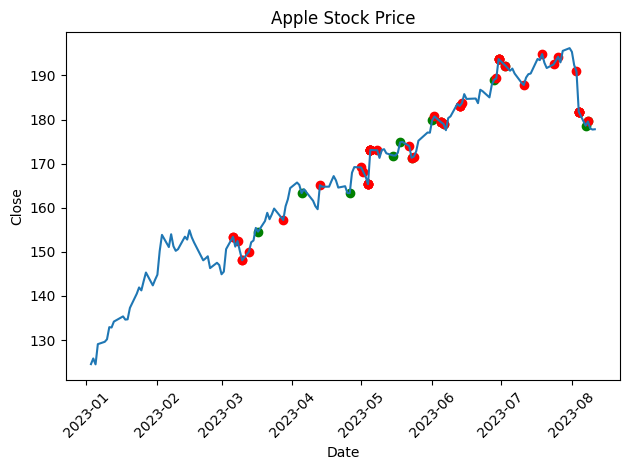

In [139]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("AAPL",apple_df)

plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Apple Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()

print(len(pos_date))
print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

14
14


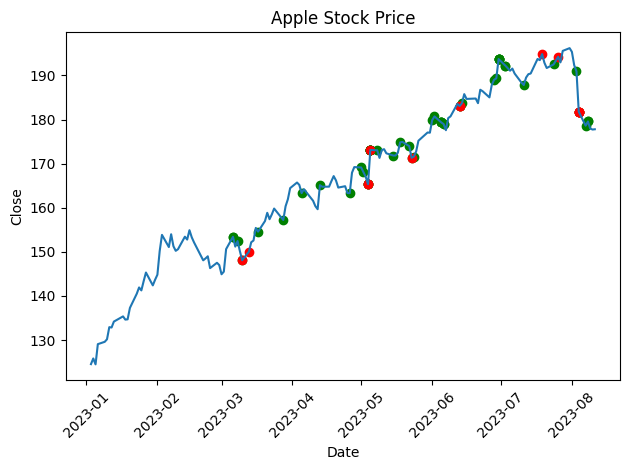

In [140]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("AAPL",apple_finbert_df)

plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Apple Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()


print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

### Measure Performance

In [141]:
temp = yf.Ticker("AAPL")
yahoo_df = temp.history(start="2023-01-01")
yahoo_df.index = yahoo_df.index.date
yahoo_df = yahoo_df.Close








In [142]:
from datetime import datetime, timedelta

def measure_performance(neg_dates, pos_dates, yahoo_df):
    neg_counter = 0
    for date_entity in neg_dates:
        date = date_entity.date()
        if date in yahoo_df.index:
            for i in range(1,3):
                time_delta = timedelta(days=i)
                if date + time_delta in yahoo_df.index:
                    if (yahoo_df.loc[date + time_delta] - yahoo_df.loc[date]) /yahoo_df.loc[date] < -0.01:
                        neg_counter += 1
                        break
    pos_counter = 0
    for date_entity in pos_dates:
        date = date_entity.date()
        if date in yahoo_df.index:
            for i in range(1,3):
                time_delta = timedelta(days=i)
                if date + time_delta in yahoo_df.index:
                    
                    if (yahoo_df.loc[date + time_delta] - yahoo_df.loc[date]) /yahoo_df.loc[date] > 0.01:
                        pos_counter += 1
                    break
    
    return neg_counter/len(neg_dates), pos_counter/len(pos_dates)
                        
            
            


    
    

In [143]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("AAPL",apple_df)
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print("neg accuracy: ", x)
print("pos accuracy: ", y)



neg accuracy:  0.17307692307692307
pos accuracy:  0.11764705882352941


In [144]:
apple_df

,news,publish_date,text,news old,stock market,stock names,stock,date_sanitized,pred,pred_prob
16,apple samsung invest arm september ipo accordi...,2023-08-08 12:50:11,"Nikkei Asia reported Tuesday that Arm, SoftBan...",Apple and Samsung to invest in Arm's September...,0.667047,"[('apple', 0.9570701122283936)]",apple,2023-08-08,0,"[0.7196102142333984, 0.2803897559642792]"
17,apple samsung invest softbanks arm ipo nikkei,2023-08-08 15:00:56,TOKYO (Reuters) -Apple and Samsung Electronics...,Apple and Samsung to invest in SoftBank's Arm ...,0.780419,"[('apple', 0.9831113219261169)]",apple,2023-08-08,1,"[0.10416014492511749, 0.8958398699760437]"
21,berkshire hathaway stock set record high risin...,2023-08-07 20:36:04,By Jonathan Stempel (Reuters) -Berkshire Hatha...,Berkshire Hathaway stock sets record high as r...,0.955374,"[('apple', 0.994111180305481)]",apple,2023-08-07,1,"[0.10416014492511749, 0.8958398699760437]"
31,apple downgraded rosenblatt valuation peak,2023-08-04 17:28:06,Apple (NASDAQ:AAPL) was cut to Neutral from Bu...,Apple downgraded at Rosenblatt as 'valuation p...,0.643293,"[('apple', 0.9912434220314026)]",apple,2023-08-04,0,"[0.7196102142333984, 0.2803897559642792]"
32,wall street end lower u job report apple weighs,2023-08-05 01:00:38,By Echo Wang (Reuters) - Wall Street closed lo...,Wall Street ends lower after US jobs report; A...,0.974950,"[('apple', 0.9949797987937927)]",apple,2023-08-05,0,"[0.7196102142333984, 0.2803897559642792]"
...,...,...,...,...,...,...,...,...,...,...
821,apple shareholder reject proposal conservative...,2023-03-10 22:00:50,By Stephen Nellis (Reuters) -Apple Inc shareho...,Apple shareholders reject proposals from conse...,0.711830,"[('apple', 0.9968996047973633)]",apple,2023-03-10,0,"[0.7196102142333984, 0.2803897559642792]"
822,analyst downgrade apple stock sell see downsid...,2023-03-10 13:34:04,By Senad Karaahmetovic Apple (NASDAQ:AAPL) sto...,"Analysts downgrade Apple stock to Sell, see 20...",0.970756,"[('apple', 0.9987367987632751)]",apple,2023-03-10,0,"[0.7196102142333984, 0.2803897559642792]"
832,apple stock price target raised wedbush positi...,2023-03-08 11:47:24,By Senad Karaahmetovic Wedbush analysts raised...,Apple stock price target raised at Wedbush on ...,0.901839,"[('apple', 0.990145742893219)]",apple,2023-03-08,0,"[0.7196102142333984, 0.2803897559642792]"
843,analyst call day apple buy say goldman pro recap,2023-03-06 12:34:10,By Davit Kirakosyan Investing.com -- Here is y...,"4 analyst calls of the day: Apple is a buy, sa...",0.497439,"[('apple', 0.993642270565033)]",apple,2023-03-06,0,"[0.7196102142333984, 0.2803897559642792]"


In [145]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("AAPL",apple_finbert_df)

In [146]:
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print("neg accuracy: ", x)
print("pos accuracy: ", y)



neg accuracy:  0.07142857142857142
pos accuracy:  0.21818181818181817


## Amazon

In [182]:
temp = yf.Ticker("AMZN")
yahoo_df = temp.history(start="2023-01-01")
yahoo_df.index = yahoo_df.index.date
yahoo_df = yahoo_df.Close

In [148]:
amazon_df = stock_market_related[stock_market_related['stock']=='amazon']
amazon_finbert_df =stock_market_related[stock_market_related['stock']=='amazon'] 
MAX_LEN = 512
BATCH_SIZE = 8

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(amazon_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_bert, data_loader)

amazon_df['pred'] = y_pred.tolist()
amazon_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
amazon_df.to_excel("amazon_predicted_investing.xlsx")

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2369075160.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_df['pred'] = y_pred.tolist()
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2369075160.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]


In [187]:

MAX_LEN = 512
BATCH_SIZE = 8

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(amazon_finbert_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_finbert, data_loader)

amazon_finbert_df['pred'] = y_pred.tolist()
amazon_finbert_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
amazon_finbert_df.to_excel("amazon_predicted_investing.xlsx")

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2595457779.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_finbert_df['pred'] = y_pred.tolist()
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2595457779.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_finbert_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]


9
23
23


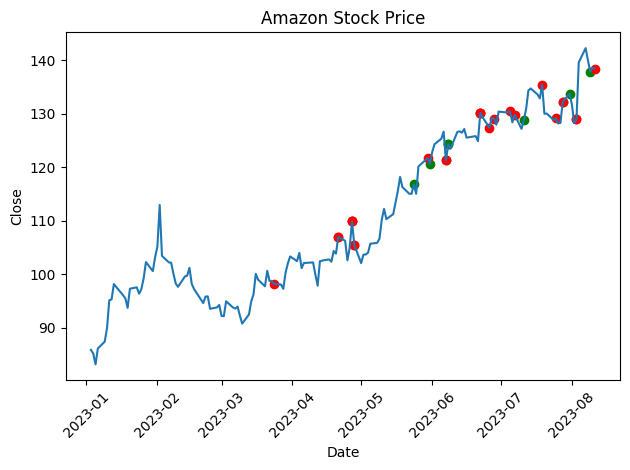

In [150]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("AMZN",amazon_df)

plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Amazon Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()

print(len(pos_date))
print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

In [151]:
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print("neg accuracy: ", x)
print("pos accuracy: ", y)

neg accuracy:  0.21739130434782608
pos accuracy:  0.4444444444444444


27
5
5


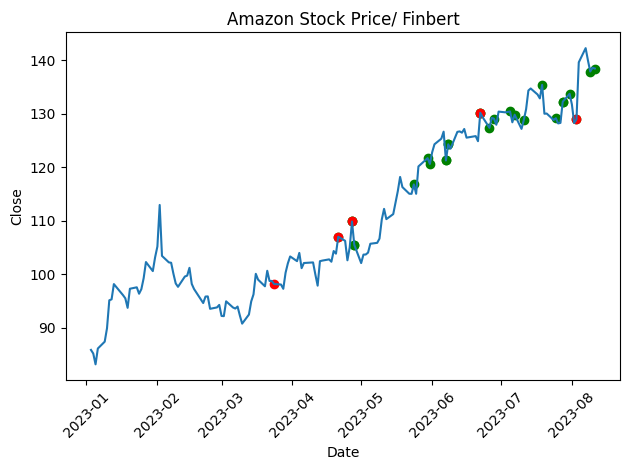

In [152]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("AMZN",amazon_finbert_df)

plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Amazon Stock Price/ Finbert')
plt.xticks(rotation=45)
plt.tight_layout()

print(len(pos_date))
print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

In [153]:
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print("neg accuracy: ", x)
print("pos accuracy: ", y)

neg accuracy:  0.2
pos accuracy:  0.2962962962962963


## Google

In [193]:
google_df = stock_market_related[stock_market_related['stock']=='google']
google_finbert_df =stock_market_related[stock_market_related['stock']=='google'] 
MAX_LEN = 512
BATCH_SIZE = 8

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(google_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_bert, data_loader)

google_df['pred'] = y_pred.tolist()
google_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
google_df.to_excel("google_predicted_investing.xlsx")

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/1482330725.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_df['pred'] = y_pred.tolist()
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/1482330725.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]


In [194]:


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
data_loader = create_data_load(google_finbert_df, tokenizer,  MAX_LEN, batch_size=BATCH_SIZE, )
y_pred, y_pred_probs = get_pred(model_finbert, data_loader)

google_finbert_df['pred'] = y_pred.tolist()
google_finbert_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]
google_finbert_df.to_excel("google_predicted_investing_finbert.xlsx")

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2086990178.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_finbert_df['pred'] = y_pred.tolist()
/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2086990178.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_finbert_df['pred_prob'] = [y_pred_probs.tolist()[y_pred.tolist()[i]] for i in range(len(y_pred_probs.tolist()))]


4
15
15


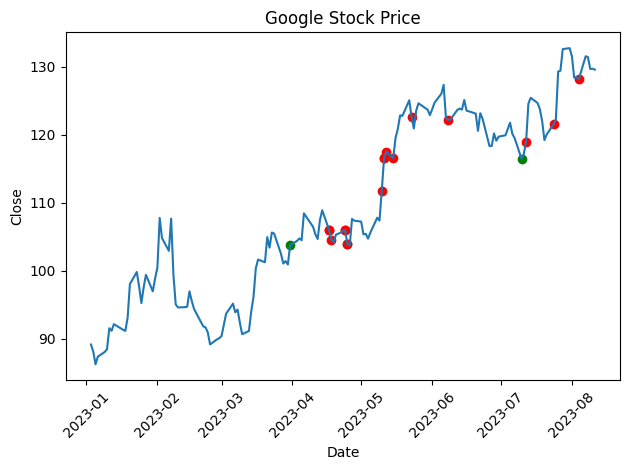

In [83]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("GOOGL",google_df)

plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Google Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()

print(len(pos_date))
print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

In [195]:
temp = yf.Ticker("GOOGL")
yahoo_df = temp.history(start="2023-01-01")
yahoo_df.index = yahoo_df.index.date
yahoo_df = yahoo_df.Close

In [92]:
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print("neg accuracy: ", x)
print("pos accuracy: ", y)

neg accuracy:  0.3333333333333333
pos accuracy:  0.5


15
4
4


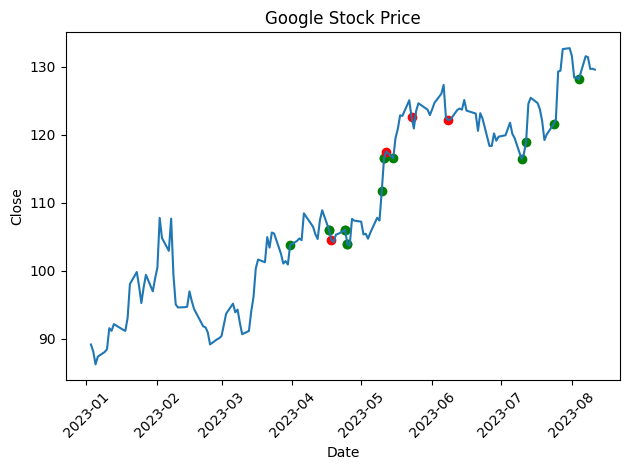

In [93]:
neg_price, neg_date, pos_price, pos_date, df = handle_dfs("GOOGL",google_finbert_df)

plt.plot(df['Date'], df['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Google Stock Price')
plt.xticks(rotation=45)
plt.tight_layout()

print(len(pos_date))
print(len(neg_date))
print(len(neg_price))
plt.scatter(pos_date, pos_price, color='green', label='Good News')
plt.scatter(neg_date, neg_price, color='red', label='Bad News')
plt.show()

In [94]:
x, y = measure_performance(neg_date, pos_date, yahoo_df)
print("neg accuracy: ", x)
print("pos accuracy: ", y)

neg accuracy:  0.25
pos accuracy:  0.4666666666666667


In [179]:
import numpy as np
def buy_sell(df_stock):

    initial_balance = 1000  # initial balance in dollars
    balance = initial_balance
    stocks_owned = 0  # number of stocks owned

    recent_sentiments = []  # store recent sentiments here
    recent_sentiments_limit = 2 # only consider the last one sentiments

    newlist = []
    newlist2 = []
    newlistbuy = []
    newlistsell = []



    buy_price = 0

    # Set a fixed amount to buy/sell
    fixed_amount = 100

    # Define thresholds
    # buy_threshold = 108 / 2
    # sell_threshold = 1000 / 108 /2

    # Loop over the DataFrame
    for index, row in df_stock.iterrows():

        #buy_threshold = row['now'] / 2
        #sell_threshold = 1000 / row['now'] /2
        # Add the sentiment to the list of recent sentiments

        recent_sentiments.append(row['pred'])
        print(recent_sentiments)

        if len(recent_sentiments) > recent_sentiments_limit:
            # If the list is too long, remove the oldest sentiment
            recent_sentiments.pop(0)

        #if row['sentiment'] == "POSITIVE" and balance > buy_threshold:
        if row['pred'] == 1 and balance > 0:
            # Buy stocks when sentiment is positive and balance is above threshold
            buy_price = row['now']
            num_stocks_to_buy = fixed_amount / row['now']
            cost = num_stocks_to_buy * row['now']
            balance -= cost  # deduct the cost from balance
            stocks_owned += num_stocks_to_buy
            print(f"Balance {balance} Buying {num_stocks_to_buy} stocks. Total owned: {stocks_owned}")
            newlistbuy.append(row['date_sanitized'])

        # Check if all recent sentiments are the same
        if len(set(recent_sentiments)) == 1:
            sentiment = recent_sentiments[0]

            #if sentiment == "NEGATIVE" and stocks_owned > sell_threshold:
            if sentiment == 0 and stocks_owned > 0:
                # Sell stocks when sentiment is negative and owned stocks are above threshold
                num_stocks_to_sell = min(stocks_owned, fixed_amount / row['now'])
                revenue = num_stocks_to_sell * row['now']
                balance += revenue  # add the revenue to balance
                stocks_owned -= num_stocks_to_sell
                print(f"Selling {num_stocks_to_sell} stocks for ${revenue}. Total owned: {stocks_owned}")
                newlistsell.append(row['date_sanitized'])

            newlist.append(balance + (stocks_owned * row['now']))
            newlist2.append(row['date_sanitized'])

        # Sell all stocks if the price drops by 5% or more
        if stocks_owned > 0 and row['now'] < 0.95 * buy_price:
            revenue = stocks_owned * row['now']
            balance += revenue
            print(f"Selling all stocks due to 5% price drop for ${revenue}. Total owned: 0")
            stocks_owned = 0
            newlistsell.append(row['date_sanitized'])

    final_balance = balance + stocks_owned * df_stock.iloc[-1]['now']
    print(f"Final balance: ${final_balance}")
    return_rate = (final_balance - initial_balance) / initial_balance
    print(f"Return rate: {return_rate*100}%")

In [154]:
apple_df.columns

Index(['news', 'publish_date', 'text', 'news old', 'stock market',
       'stock names', 'stock', 'date_sanitized', 'pred', 'pred_prob'],
      dtype='object')

In [155]:
print(apple_df)

                                                  news         publish_date  \
16   apple samsung invest arm september ipo accordi...  2023-08-08 12:50:11   
17       apple samsung invest softbanks arm ipo nikkei  2023-08-08 15:00:56   
21   berkshire hathaway stock set record high risin...  2023-08-07 20:36:04   
31          apple downgraded rosenblatt valuation peak  2023-08-04 17:28:06   
32     wall street end lower u job report apple weighs  2023-08-05 01:00:38   
..                                                 ...                  ...   
821  apple shareholder reject proposal conservative...  2023-03-10 22:00:50   
822  analyst downgrade apple stock sell see downsid...  2023-03-10 13:34:04   
832  apple stock price target raised wedbush positi...  2023-03-08 11:47:24   
843   analyst call day apple buy say goldman pro recap  2023-03-06 12:34:10   
844  goldman start apple stock buy see upside poten...  2023-03-06 11:24:44   

                                                  t

In [156]:
temp = yf.Ticker("AAPL")
yf_df = temp.history(start="2023-01-01")
yf_df = yf_df.Close
yf_df.index = yf_df.index.date
apple_df.sort_values(by=['date_sanitized'], ascending=True, inplace=True)



/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/3822823342.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.sort_values(by=['date_sanitized'], ascending=True, inplace=True)


In [189]:

def match_value(apple_df, yd_df):
    apple_df.sort_values(by=['date_sanitized'], inplace=True)
    temp = apple_df.copy()
    temp['now'] = None

    for index, row in temp.iterrows():
        try:
            print(yf_df[pd.to_datetime(row.loc['date_sanitized']).date()])
            price = yf_df[pd.to_datetime(row.loc['date_sanitized']).date()]
            temp.at[index, 'now'] = price

        except:
            continue

    temp = temp.dropna()
    return temp




In [177]:
apple_df

,news,publish_date,text,news old,stock market,stock names,stock,date_sanitized,pred,pred_prob,now
844,goldman start apple stock buy see upside poten...,2023-03-06 11:24:44,By Senad Karaahmetovic Goldman Sachs initiated...,"Goldman starts Apple stock at Buy, sees over 3...",0.954675,"[('apple', 0.9963088631629944)]",apple,2023-03-06,0,"[0.7196102142333984, 0.2803897559642792]",153.41037
843,analyst call day apple buy say goldman pro recap,2023-03-06 12:34:10,By Davit Kirakosyan Investing.com -- Here is y...,"4 analyst calls of the day: Apple is a buy, sa...",0.497439,"[('apple', 0.993642270565033)]",apple,2023-03-06,0,"[0.7196102142333984, 0.2803897559642792]",153.41037
832,apple stock price target raised wedbush positi...,2023-03-08 11:47:24,By Senad Karaahmetovic Wedbush analysts raised...,Apple stock price target raised at Wedbush on ...,0.901839,"[('apple', 0.990145742893219)]",apple,2023-03-08,0,"[0.7196102142333984, 0.2803897559642792]",152.452972
822,analyst downgrade apple stock sell see downsid...,2023-03-10 13:34:04,By Senad Karaahmetovic Apple (NASDAQ:AAPL) sto...,"Analysts downgrade Apple stock to Sell, see 20...",0.970756,"[('apple', 0.9987367987632751)]",apple,2023-03-10,0,"[0.7196102142333984, 0.2803897559642792]",148.094894
821,apple shareholder reject proposal conservative...,2023-03-10 22:00:50,By Stephen Nellis (Reuters) -Apple Inc shareho...,Apple shareholders reject proposals from conse...,0.711830,"[('apple', 0.9968996047973633)]",apple,2023-03-10,0,"[0.7196102142333984, 0.2803897559642792]",148.094894
...,...,...,...,...,...,...,...,...,...,...,...
38,stock market today dow snap three week win str...,2023-08-04 20:17:46,"Investing.com -- The Dow closed lower Friday, ...",Stock market today: Dow snaps three-week win s...,0.997833,"[('apple', 0.9717243313789368)]",apple,2023-08-04,0,"[0.7196102142333984, 0.2803897559642792]",181.744583
31,apple downgraded rosenblatt valuation peak,2023-08-04 17:28:06,Apple (NASDAQ:AAPL) was cut to Neutral from Bu...,Apple downgraded at Rosenblatt as 'valuation p...,0.643293,"[('apple', 0.9912434220314026)]",apple,2023-08-04,0,"[0.7196102142333984, 0.2803897559642792]",181.744583
21,berkshire hathaway stock set record high risin...,2023-08-07 20:36:04,By Jonathan Stempel (Reuters) -Berkshire Hatha...,Berkshire Hathaway stock sets record high as r...,0.955374,"[('apple', 0.994111180305481)]",apple,2023-08-07,1,"[0.10416014492511749, 0.8958398699760437]",178.60881
17,apple samsung invest softbanks arm ipo nikkei,2023-08-08 15:00:56,TOKYO (Reuters) -Apple and Samsung Electronics...,Apple and Samsung to invest in SoftBank's Arm ...,0.780419,"[('apple', 0.9831113219261169)]",apple,2023-08-08,1,"[0.10416014492511749, 0.8958398699760437]",179.557526


In [180]:
buy_sell(apple_df, yf_df)

[0]
[0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
Balance 900.0 Buying 0.6469260892668371 stocks. Total owned: 0.6469260892668371
[0, 1, 0]
[1, 0, 1]
Balance 800.0 Buying 0.6123201398350241 stocks. Total owned: 1.2592462291018611
[0, 1, 0]
[1, 0, 1]
Balance 700.0 Buying 0.6123201398350241 stocks. Total owned: 1.871566368936885
[0, 1, 0]
[1, 0, 0]
Selling 0.5949539667804054 stocks for $100.0. Total owned: 1.2766124021564798
[0, 0, 0]
Selling 0.6048226522030722 stocks for $99.99999999999999. Total owned: 0.6717897499534076
[0, 0, 0]
Selling 0.6048226522030722 stocks for $99.99999999999999. Total owned: 0.06696709775033538
[0, 0, 0]
Selling 0.06696709775033538 stocks for $11.072187443113629. Total owned: 0.0
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
Balance 911.0721874431136 Buying 0.5777123925637513 stocks. Total owned: 0.5777123925637513
[0, 1, 0]
[1, 0, 0]
Selling 0.5777123925637513 stocks for $100.00000000000001. Total owned: 0.0
[0, 0, 1]
Balance 911.0721874431136 Buying 0.5

,news,publish_date,text,news old,stock market,stock names,stock,date_sanitized,pred,pred_prob
61,u stock falling investor await apple amazon ea...,2023-08-03 15:24:39,Investing.com -- U.S. stocks were falling on T...,U.S. stocks are falling as investors await App...,0.970335,"[('amazon', 0.9014427065849304), ('apple', 0.8...",amazon,2023-08-03,0,"[0.9703143239021301, 0.02968565560877323]"
64,apple amazon report adidas narrow loss forecas...,2023-08-03 09:25:25,"Investing.com -- U.S. stock futures slip, sugg...","Apple and Amazon to report, Adidas narrows los...",0.587000,"[('amazon', 0.970618724822998), ('apple', 0.96...",amazon,2023-08-03,0,"[0.9703143239021301, 0.02968565560877323]"
97,u stock rising another week megacap earnings kick,2023-07-31 16:04:05,Investing.com -- U.S. stocks were rising ahead...,U.S. stocks are rising as another week of mega...,0.987390,"[('amazon', 0.43442898988723755)]",amazon,2023-07-31,1,"[0.9671081304550171, 0.032891836017370224]"
188,midday mover amazon wd jpmorgan zillow rise,2023-07-11 16:47:49,Investing.com -- U.S. stocks were rising as in...,"Midday movers: Amazon, WD-40, JPMorgan and Zil...",0.991871,"[('amazon', 0.9922570586204529)]",amazon,2023-07-11,1,"[0.9671081304550171, 0.032891836017370224]"
199,top company buying back stock,2023-07-07 12:08:06,NaN,Top 7 companies buying back the most stock,0.419472,"[('amazon', 0.41341835260391235)]",amazon,2023-07-07,0,"[0.9703143239021301, 0.02968565560877323]"
392,surging u megacap stock leave wondering cash,2023-06-04 13:00:46,By Lewis Krauskopf NEW YORK (Reuters) -As the ...,Surging US megacap stocks leave some wondering...,0.982729,"[('amazon', 0.4281002879142761)]",amazon,2023-06-04,0,"[0.9703143239021301, 0.02968565560877323]"
417,factbox megacap stock fared hitting trillion m...,2023-05-30 22:12:15,NEW YORK (Reuters) - A mammoth run in shares o...,Factbox-How megacap stocks fared after hitting...,0.979634,"[('amazon', 0.5405914187431335)]",amazon,2023-05-30,0,"[0.9703143239021301, 0.02968565560877323]"
613,u megacaps soar investor wary rising valuation,2023-04-27 18:17:19,By Lewis Krauskopf NEW YORK (Reuters) - Some m...,"As U.S. megacaps soar, some investors are wary...",0.984838,"[('amazon', 0.4124472737312317)]",amazon,2023-04-27,0,"[0.9703143239021301, 0.02968565560877323]"
774,strength megacap stock mask broader u market woe,2023-03-24 22:40:45,By Lewis Krauskopf NEW YORK (Reuters) - Invest...,Strength in megacap stocks masks broader U.S. ...,0.946355,"[('amazon', 0.40008899569511414)]",amazon,2023-03-24,0,"[0.9703143239021301, 0.02968565560877323]"
888,prominent investor rekindle affection amazon q...,2023-08-11 22:30:41,By Svea Herbst-Bayliss NEW YORK (Reuters) - Se...,Prominent investors rekindle affection for Ama...,0.963339,"[('amazon', 0.9889447093009949)]",amazon,2023-08-11,0,"[0.9703143239021301, 0.02968565560877323]"


In [190]:
x =match_value(amazon_df,yahoo_df)
buy_sell(x)

159.81283569335938
164.56983947753906
164.56983947753906
167.95059204101562
167.95059204101562
167.95059204101562
169.2171173095703
169.2171173095703
171.60826110839844
177.06089782714844
177.01097106933594
177.5802001953125
177.5802001953125
180.3264923095703
180.3264923095703
186.74781799316406
186.74781799316406
186.74781799316406
185.02015686035156
188.99478149414062
191.0719757080078
190.4228515625
187.8263702392578
194.83689880371094
193.35888671875
195.56591796875
195.56591796875
196.18507385253906
190.91220092773438
190.91220092773438
177.94970703125
177.7899932861328
[0]
[0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
Balance 900.0 Buying 0.5827225295222459 stocks. Total owned: 0.5827225295222459
[0, 1, 0]
[1, 0, 1]
Balance 800.0 Buying 0.5649367346887758 stocks. Total owned: 1.1476592642110217
[0, 1, 0]
[1, 0, 1]
Balance 700.0 Buying 0.5631258433655018 stocks. Total owned: 1.7107851075765235
[0, 1, 1]
Balance 600.0 Buying 0.5545496877315612 stocks. Total ow

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2485231749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.sort_values(by=['date_sanitized'], inplace=True)


In [192]:
x =match_value(amazon_finbert_df,yahoo_df)
buy_sell(x)

159.81283569335938
164.56983947753906
164.56983947753906
167.95059204101562
167.95059204101562
167.95059204101562
169.2171173095703
169.2171173095703
171.60826110839844
177.06089782714844
177.01097106933594
177.5802001953125
177.5802001953125
180.3264923095703
180.3264923095703
186.74781799316406
186.74781799316406
186.74781799316406
185.02015686035156
188.99478149414062
191.0719757080078
190.4228515625
187.8263702392578
194.83689880371094
193.35888671875
195.56591796875
195.56591796875
196.18507385253906
190.91220092773438
190.91220092773438
177.94970703125
177.7899932861328
[0]
[0, 1]
Balance 900.0 Buying 0.6076447562777642 stocks. Total owned: 0.6076447562777642
[0, 1, 1]
Balance 800.0 Buying 0.5954132032805145 stocks. Total owned: 1.2030579595582787
[1, 1, 0]
[1, 0, 1]
Balance 700.0 Buying 0.5954132032805145 stocks. Total owned: 1.7984711628387933
[0, 1, 1]
Balance 600.0 Buying 0.5909567636532735 stocks. Total owned: 2.3894279264920666
[1, 1, 1]
Balance 500.0 Buying 0.5909567636532

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2485231749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.sort_values(by=['date_sanitized'], inplace=True)


In [196]:
x =match_value(google_df,yahoo_df)
buy_sell(x)

164.4501495361328
164.7792510986328
164.7792510986328
166.01588439941406
164.8789825439453
164.8789825439453
163.3232421875
163.3232421875
173.08653259277344
173.27601623535156
173.27601623535156
172.3372802734375
171.8379669189453
171.32864379882812
180.3264923095703
188.35565185546875
189.5140838623047
192.4900665283203
181.7445831298828
[1]
Balance 900.0 Buying 0.6080870116693211 stocks. Total owned: 0.6080870116693211
[1, 0]
[1, 0, 0]
Selling 0.6068725238964854 stocks for $100.0. Total owned: 0.0012144877728357262
[0, 0, 0]
Selling 0.0012144877728357262 stocks for $0.20162426169959777. Total owned: 0.0
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 1]
Balance 900.2016242616996 Buying 0.6122827263323427 stocks. Total owned: 0.6122827263323427
[0, 1, 0]
[1, 0, 0]
Selling 0.5771139143929495 stocks for $100.0. Total owned: 0.03516881193939325
[0, 0, 1]
Balance 900.2016242616996 Buying 0.5771139143929495 stocks. Total owned: 0.6122827263323427
[0, 1, 0]
[1, 0, 0]
Selling 0.5836735631749861 stocks

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2485231749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.sort_values(by=['date_sanitized'], inplace=True)


In [197]:
x =match_value(google_finbert_df,yahoo_df)
buy_sell(x)

164.4501495361328
164.7792510986328
164.7792510986328
166.01588439941406
164.8789825439453
164.8789825439453
163.3232421875
163.3232421875
173.08653259277344
173.27601623535156
173.27601623535156
172.3372802734375
171.8379669189453
171.32864379882812
180.3264923095703
188.35565185546875
189.5140838623047
192.4900665283203
181.7445831298828
[1]
Balance 900.0 Buying 0.6080870116693211 stocks. Total owned: 0.6080870116693211
[1, 1]
Balance 800.0 Buying 0.6068725238964854 stocks. Total owned: 1.2149595355658065
[1, 1, 1]
Balance 700.0 Buying 0.6068725238964854 stocks. Total owned: 1.8218320594622919
[1, 1, 0]
[1, 0, 1]
Balance 600.0 Buying 0.6065054408820538 stocks. Total owned: 2.4283375003443455
[0, 1, 1]
Balance 500.0 Buying 0.6065054408820538 stocks. Total owned: 3.0348429412263993
[1, 1, 1]
Balance 400.0 Buying 0.6122827263323427 stocks. Total owned: 3.647125667558742
[1, 1, 1]
Balance 300.0 Buying 0.6122827263323427 stocks. Total owned: 4.259408393891085
[1, 1, 1]
Balance 200.0 Buyin

/var/folders/gc/x802xnyx4rj6hr9pwwb2qr0r0000gn/T/ipykernel_61886/2485231749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df.sort_values(by=['date_sanitized'], inplace=True)
